In [237]:
import os
# import tabula
import pandas as pd
import PyPDF2
import re
import camelot
import numpy as np

In [157]:
stockA = pd.read_csv("../data/stockAssesment2020/StockAssessment.csv")

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3791297337.py:1: DtypeWarning: Columns (55,63,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  stockA = pd.read_csv("../data/stockAssesment2020/StockAssessment.csv")


In [158]:
stockA[stockA['StockDescription'].str.contains("Blue ling")].StockDescription.unique()

array(['Blue ling (Molva dypterygia) in subareas 6-7 and Division 5.b (Celtic Seas and Faroes grounds)'],
      dtype=object)

In [821]:
fishStock = 'sol.27.7e' 

In [822]:
# get page number in which Table 6 lies, and also get the next one as tables can span two oages
obj = PyPDF2.PdfFileReader("../data/pdfsICES/{}.pdf".format(fishStock))

pgno = obj.getNumPages()

#in some pdfs the Table 6 has more than one space between Table and 6
s = "Table[ ]{1,}6" 

for i in range(0, pgno):
    PgOb = obj.getPage(i)
    Text = PgOb.extractText()
    if re.search(s,Text):
         pages=str(i+1) + ',' + str(i+2)
         print(pages)

3,4


In [823]:
# from camelot import utils
# layout, dim = utils.get_page_layout(r'C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf')

In [824]:
# table_areas accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2)
tables = camelot.read_pdf("../data/pdfsICES/{}.pdf".format(fishStock), 
                           pages=pages, 
                           backend="poppler", 
                           # flavor='stream',
                           # table_area=['0,600,590,700'],
                           # iterations=1,
                           line_scale=30,
                           # split_text=True,
                           strip_text=['#','^','<', '-', '≤', '***', '\n'],
                          )
print("Total tables extracted:", tables.n)

Total tables extracted: 8


In [829]:
# delete tables before the first table in list that corresponds to table 6 (Advice) 
firstAdvice = [i for i, elem in enumerate(tables) if 'ICES advice' in tables[i].df.iloc[0,:].to_list()][0]
tables = tables[firstAdvice:]

In [831]:
# filter tables by two conditions:
# [0][0] is numeric and len(columns) is equal to the len(first table 6) 
# or the first row is equal to the first row of the first table 6
filterTableSix = [i for i, elem in enumerate(tables) if (pd.to_numeric(tables[i].df[0][0], errors='coerce')> 0 and\
len(tables[i].df.columns) == len(tables[0].df.columns))\
or tables[i].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True
    ]

tableSix = [tables[i].df for i in filterTableSix]
tableSix = pd.concat(tableSix)

In [832]:
# fix table 
icesTable = tableSix.copy()
icesTable.columns = icesTable.iloc[0,:]
icesTable = icesTable[1:]
icesTable['fishStock'] = fishStock
# sometimes the columns Year and ICES advice (text) don't split, we strip the text
icesTable['Year'] = icesTable['Year'].str.extract('(\d+)', expand=False)
icesTable = icesTable[icesTable['Year'].astype(str).str.isnumeric()]

# sometimes there is more than one space between the words in the columns
icesTable.rename(columns=lambda x: re.sub(r'[^a-zA-Z]+', ' ', x).strip(), inplace=True)

icesTable = icesTable.rename(columns={
'Predicted catch corresponding to advice':'SAD',
'Catch corresponding to advice': 'SAD',
'Catches corresponding to advice': 'SAD',
'Landings corresponding to advice': 'SAD_landings',
'Agreed TAC': 'TAC',
'ICES landings': 'Landings',
'ICES catch':'Catches (stockass)'})

# apply numeric transformation with conditional as pdfs have different columns
numericCol = ['SAD', 'SAD_landings', 'TAC', 'Landings', 'Year', 'Catches (stockass)']
for col in icesTable.columns:
    if col in numericCol:
        icesTable[col] = icesTable[col].replace({' ': ''}, regex=True)
        # for cases in which there is an explanation of the number, we strip it
        icesTable[col] = icesTable[col].str.split('(').str[0]
        icesTable[col] = icesTable[col].apply(pd.to_numeric, errors='coerce')

icesTable

,Year,ICES advice,SAD,SAD_landings,TAC,Official landings,Landings,ICES discards,fishStock
1,1987,No increase in F,NaN,1150.0,1150.0,1110,1280.0,,sol.27.7e
2,1988,No decrease in SSB; TAC,NaN,1300.0,1300.0,950,1444.0,,sol.27.7e
3,1989,No decrease in SSB; TAC,NaN,1000.0,1000.0,800,1390.0,,sol.27.7e
4,1990,SSB = 3000 tonnes; TAC,NaN,900.0,900.0,750,1315.0,,sol.27.7e
5,1991,TAC,NaN,540.0,800.0,840,852.0,,sol.27.7e
6,1992,70% of F1990,NaN,770.0,800.0,770,895.0,,sol.27.7e
7,1993,35% reduction in F,NaN,700.0,900.0,790,904.0,,sol.27.7e
8,1994,No increase in F,NaN,1000.0,1000.0,840,800.0,,sol.27.7e
9,1995,No increase in F,NaN,860.0,950.0,880,856.0,,sol.27.7e
10,1996,F1996 F1994,NaN,680.0,700.0,740,833.0,,sol.27.7e


In [833]:
# add columns from excel and reorganize
excelTable = (icesTable.reindex(['fishStock', 'Most recent assessment with corresponding report',
 'Year','Catches (stockass)', 'SAD','TAC', 'Catches (pdfs)','done?', 'report','Landings','SAD_landings'], axis=1))
    
# icesTable = icesTable.replace('','N/A')
excelTable.set_index('fishStock', inplace=True)
excelTable.to_csv("../dataTemp/icesAdvice/{}.csv".format(fishStock))
excelTable

,Most recent assessment with corresponding report,Year,Catches (stockass),SAD,TAC,Catches (pdfs),done?,report,Landings,SAD_landings
fishStock,,,,,,,,,,
sol.27.7e,NaN,1987,NaN,NaN,1150.0,NaN,NaN,NaN,1280.0,1150.0
sol.27.7e,NaN,1988,NaN,NaN,1300.0,NaN,NaN,NaN,1444.0,1300.0
sol.27.7e,NaN,1989,NaN,NaN,1000.0,NaN,NaN,NaN,1390.0,1000.0
sol.27.7e,NaN,1990,NaN,NaN,900.0,NaN,NaN,NaN,1315.0,900.0
sol.27.7e,NaN,1991,NaN,NaN,800.0,NaN,NaN,NaN,852.0,540.0
sol.27.7e,NaN,1992,NaN,NaN,800.0,NaN,NaN,NaN,895.0,770.0
sol.27.7e,NaN,1993,NaN,NaN,900.0,NaN,NaN,NaN,904.0,700.0
sol.27.7e,NaN,1994,NaN,NaN,1000.0,NaN,NaN,NaN,800.0,1000.0
sol.27.7e,NaN,1995,NaN,NaN,950.0,NaN,NaN,NaN,856.0,860.0


C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3259206825.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='text').show()


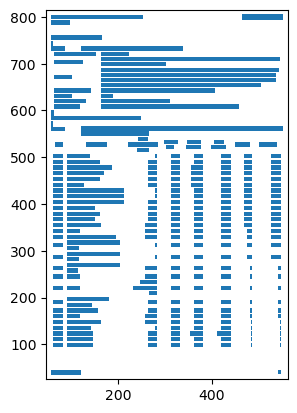

In [803]:
camelot.plot(tables[0], kind='text').show()

#### Trash

In [ ]:
# if len(tables) > 1:
#     # if table in same page is divided in two, then concatenate
#     if pd.to_numeric(tables[1].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     # if table is divided in two pages, then concatenate
#     elif tables[1].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     else:
#         tableSix = tables[0].df
# if len(tables) > 2:
#     # if table is divided in two pages, then concatenate
#     if tables[2].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tableSix, tables[2].df])
#     elif pd.to_numeric(tables[2].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tableSix, tables[2].df])
        
# tableSix

#### From tabula

In [162]:
# tables = tabula.read_pdf(r"C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf", multiple_tables=True, 
#                           pages=page, lattice=True, guess=True, java_options="-Dfile.encoding=UTF8")                        


In [159]:
# tabula.convert_into("file:///C:/Users/isaldiviagonzatti/OneDrive%20-%20Kiel%20Institut%20f%C3%BCr%20Weltwirtschaft/Documents/General/Ignacio/data/pdf_ices_test/bli.27.5b67.pdf", r"C:/Users/isaldiviagonzatti//Downloads/test.csv", output_format="csv", stream=True, pages='4')

In [ ]:
# i=1
# for table in tables:
#     table.columns = table.iloc[0]
#     table = table.reindex(table.index.drop(0)).reset_index(drop=True)
#     table.columns.name = None
#     #To write Excel
#     table.to_excel('output'+str(i)+'.xlsx',header=True,index=False)
#     #To write CSV
#     table.to_csv('output'+str(i)+'.csv',sep='|',header=True,index=False)
#     i=i+1